# Percentage of Volume (POV) v1 using Minute Bar Data

In [ ]:
# TODO: implement target function and tolerance functions

## Parameters
Parameters: &lt;side&gt; &lt;quantity&gt; &lt;pct_volume&gt; [limit_px] 

side = "b" (buy) or "s" (sell)

quantity = # of shares

pct_volume = percentage of volume to target

limit_px = limit price (optional)

### Structure
1. Get market data
1. Determine order parameters 
1. Initiate loop (reading market data)
    1. Read each bin of data
    1. Calculate % of volume and bin price (last for now)
    1. Accumulate the trade per bin
1. Calculate and plot summary statistics (average price, slippage vs. vwap, vs. arrival, vs. interval vwap

In [3]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%run getstock.py

In [4]:
# get our market data, plot it to sanity check
bars = getMinuteStockPrices(symbol='AAPL')
bars.head()

,open,high,low,close,volume
timestamp,,,,,
2019-04-08 09:31:00,196.6421,196.6421,196.6421,196.6421,531952
2019-04-08 09:32:00,196.6900,197.1700,196.6600,197.0800,177215
2019-04-08 09:33:00,197.0427,197.4234,196.9500,197.2250,122708
2019-04-08 09:34:00,197.3000,197.3000,197.3000,197.3000,101819
2019-04-08 09:35:00,197.2900,197.3100,196.6600,196.8600,178622


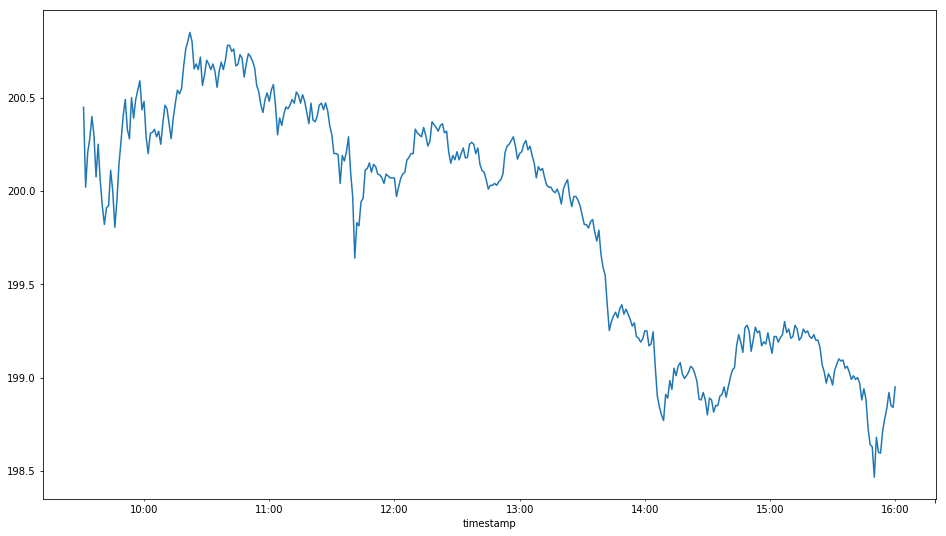

In [5]:
day = bars[ '2019-04-11' ]
day['close'].plot(figsize=(16,9))

In [16]:
# order parameters
quantity = 1000000
pct_volume = 0.30
quantity_remaining = quantity
trades = pd.DataFrame( columns = [ 'price' , 'shares'], index=day.index )

# main event loop
for index, row in day.iterrows() :
    # Read each bin of data
    # calculate midpoint of that bar
    px = ( row[ 'high' ] + row[ 'low' ] ) / 2 
    volume = row[ 'volume' ]
    
    # Calculate % of volume and bin price (last for now)
    new_trade = min( pct_volume * volume, quantity_remaining )
    
    # Accumulate the trade per bin
    trades.loc[index] = [px, new_trade]
    
    # decrement the remaining qty, and bail out if it's zero
    quantity_remaining -= new_trade
    
    # debug
    #print( str(volume) + " " + str(new_trade) + " " + str(quantity_remaining) )
    
    if ( quantity_remaining <= 0 ):
        break
  

In [17]:
trades['shares'].sum()

999999.9999999998

### Analysis of POV Order

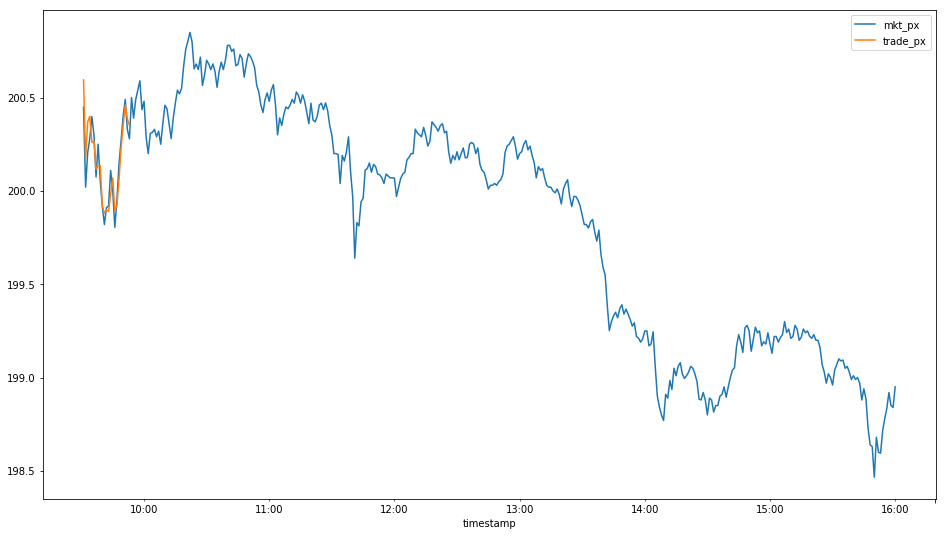

In [18]:
trade_results = pd.DataFrame(index = day.index)
trade_results['mkt_px'] = pd.Series(day['close'])
trade_results['trade_px'] = pd.Series(trades['price'])
trade_results.plot( figsize=(16,9) )

### Let's look at the trade sizes

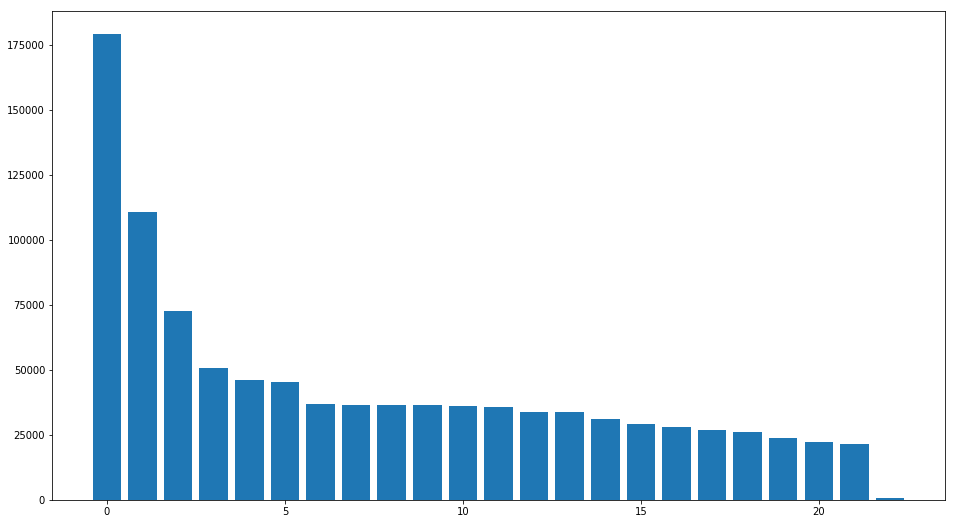

In [19]:
fig, ax1 = plt.subplots(figsize=(16,9))
raw_bar_array = trades['shares'].dropna().sort_values(ascending=False).values
x = np.arange(len(raw_bar_array))
ax1.bar(x, raw_bar_array)
plt.show()

### Summary Stats of POV

In [20]:
# calculate VWAP
vwap = ( day[ 'close' ] * day[ 'volume' ] ).sum() / day[ 'volume' ].sum()

# average trade price
pavg = ( trades[ 'price' ] * trades[ 'shares' ] ).sum() /  trades[ 'shares' ].sum()

slippage =  ( ( vwap - pavg ) / vwap ) * 10000

print( "VWAP: " + str( vwap ) )
print( "Pavg: " + str( pavg ) )
print( "Performance vs Day VWAP in bps: " + str( slippage ) )
print( "Average Trade Size: {0:.2f}".format(trades['shares'].mean()))

VWAP: 199.8108708283687
Pavg: 200.23427644844003
Performance vs Day VWAP in bps: -21.190319541473468
Average Trade Size: 43478.26
